# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [5]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

os.chdir('/content/drive/MyDrive/nyc_taxi_data')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        data = pd.read_parquet(file_path)
        data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
        # Extract date and hour from pickup datetime
        data['pickup_date'] = data['tpep_pickup_datetime'].dt.date
        data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for date in data['pickup_date'].unique():
            daily_data = data[data['pickup_date'] == date]

            # Iterate through each hour of the selected date
            for hour in range(24):
                hour_data = daily_data[daily_data['pickup_hour'] == hour]

                # Sample 5% of the hourly data randomly
                if not hour_data.empty:
                    sample = hour_data.sample(frac=0.05, random_state=42)

                    # add data of this hour to the dataframe
                    sampled_data = pd.concat([sampled_data, sample], ignore_index=True)

        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data], ignore_index=True)

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [8]:
df.to_parquet('/content/drive/MyDrive/nyc_taxi_data/sample_df.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [9]:
# Load the new data file
path = '/content/drive/MyDrive/nyc_taxi_data/sample_df.parquet'
df = pd.read_parquet(path)




In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_date,pickup_hour,airport_fee
0,2,2023-09-01 00:39:59,2023-09-01 01:00:28,NaN,4.71,NaN,None,113,238,0,...,0.5,4.32,0.00,1.0,33.15,NaN,NaN,2023-09-01,0,NaN
1,2,2023-09-01 00:24:50,2023-09-01 00:27:19,2.0,0.56,1.0,N,142,142,2,...,0.5,0.00,0.00,1.0,10.10,2.5,0.00,2023-09-01,0,NaN
2,2,2023-09-01 00:19:27,2023-09-01 01:04:02,2.0,18.46,2.0,N,132,163,1,...,0.5,15.71,6.94,1.0,98.40,2.5,1.75,2023-09-01,0,NaN
3,2,2023-09-01 00:42:13,2023-09-01 01:20:20,2.0,13.71,1.0,N,249,180,4,...,0.5,0.00,0.00,1.0,64.70,2.5,0.00,2023-09-01,0,NaN
4,2,2023-09-01 00:11:38,2023-09-01 00:17:56,1.0,0.71,1.0,N,144,232,1,...,0.5,2.00,0.00,1.0,14.90,2.5,0.00,2023-09-01,0,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976067 entries, 0 to 1976066
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [12]:
# Fix the index and drop any columns that are not needed
df.reset_index(drop=True, inplace=True)

columns_to_drop = ['pickup_date', 'pickup_hour']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
# Drop completely null or constant columns if needed
df = df.dropna(axis=1, how='all')  # drops columns that are all NaN
df = df.loc[:, df.nunique() > 1]  # drops columns with only one unique value





**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [13]:
# Combine the two airport fee columns

print(df[['Airport_fee', 'airport_fee']].describe())
df['airport_fee'] = df['airport_fee'].combine_first(df['Airport_fee'])
df.drop(columns=['Airport_fee'], inplace=True)


        Airport_fee    airport_fee
count  1.752624e+06  155904.000000
mean   1.456905e-01       0.108833
std    4.730301e-01       0.352445
min   -1.750000e+00      -1.250000
25%    0.000000e+00       0.000000
50%    0.000000e+00       0.000000
75%    0.000000e+00       0.000000
max    1.750000e+00       1.250000


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [14]:
# check where values of fare amount are negative
negative_fare_rows = df[df['fare_amount'] < 0]
print(negative_fare_rows)



Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee]
Index: []


Did you notice something different in the `RatecodeID` column for above records?

In [15]:
# Analyse RatecodeID for the negative fare amounts
ratecode_analysis = negative_fare_rows.groupby('RatecodeID').size().reset_index(name='count')
print(ratecode_analysis)


Empty DataFrame
Columns: [RatecodeID, count]
Index: []


In [16]:
# Find which columns have negative values
# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Check for negative values in each numeric column
negative_value_columns = {}
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        negative_value_columns[col] = negative_count

# Display the columns and count of negative values
for col, count in negative_value_columns.items():
    print(f"Column '{col}' has {count} negative values")



Column 'extra' has 3 negative values
Column 'mta_tax' has 79 negative values
Column 'improvement_surcharge' has 84 negative values
Column 'total_amount' has 84 negative values
Column 'congestion_surcharge' has 59 negative values
Column 'airport_fee' has 17 negative values


In [17]:
# fix these negative values

# Fix specific columns with appropriate values
df['extra'] = df['extra'].mask(df['extra'] < 0, df['extra'].median())
df['total_amount'] = df['total_amount'].mask(df['total_amount'] < 0, df['total_amount'].median())
df['mta_tax'] = df['mta_tax'].mask(df['mta_tax'] < 0, df['mta_tax'].mean())
df['improvement_surcharge'] = df['improvement_surcharge'].mask(df['improvement_surcharge'] < 0, df['improvement_surcharge'].mean())
df['congestion_surcharge'] = df['congestion_surcharge'].mask(df['congestion_surcharge'] < 0, df['congestion_surcharge'].median())
df['airport_fee'] = df['airport_fee'].mask(df['airport_fee'] < 0, df['total_amount'].mean())


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [18]:
# Find the proportion of missing values in each column
missing_proportions = df.isnull().mean().sort_values(ascending=False)
print(missing_proportions)


store_and_fwd_flag       0.034178
RatecodeID               0.034178
passenger_count          0.034178
airport_fee              0.034178
congestion_surcharge     0.034178
VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
DOLocationID             0.000000
PULocationID             0.000000
trip_distance            0.000000
fare_amount              0.000000
payment_type             0.000000
extra                    0.000000
mta_tax                  0.000000
tolls_amount             0.000000
tip_amount               0.000000
total_amount             0.000000
improvement_surcharge    0.000000
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [19]:
# Display the rows with null values
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

# Impute NaN values in 'passenger_count'
df['passenger_count'].describe()
df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)
df['passenger_count'] = df['passenger_count'].mask(df['passenger_count'] <= 0, df['passenger_count'].median())

df['passenger_count'].describe()



         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-09-01 00:39:59   2023-09-01 01:00:28              NaN   
85              2  2023-09-01 00:01:15   2023-09-01 00:07:07              NaN   
151             2  2023-09-01 01:58:13   2023-09-01 02:12:29              NaN   
203             2  2023-09-01 01:08:34   2023-09-01 01:20:38              NaN   
251             1  2023-09-01 02:29:04   2023-09-01 02:45:34              NaN   
...           ...                  ...                   ...              ...   
1976029         2  2023-12-31 20:15:12   2023-12-31 20:18:23              NaN   
1976039         2  2023-12-31 21:23:44   2023-12-31 21:46:55              NaN   
1976043         2  2023-12-31 21:33:12   2023-12-31 21:44:45              NaN   
1976049         2  2023-12-31 22:26:10   2023-12-31 22:44:59              NaN   
1976051         1  2023-12-31 22:05:23   2023-12-31 22:20:02              NaN   

         trip_distance  Rat

,passenger_count
count,1.976067e+06
mean,1.371853e+00
std,8.640893e-01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,9.000000e+00


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [20]:
# Fix missing values in 'RatecodeID'
print(df['RatecodeID'].value_counts(dropna=False))
print(df['RatecodeID'].describe())
df['RatecodeID'].fillna(df['RatecodeID'].median(), inplace=True)
df['RatecodeID'].describe()


RatecodeID
1.0     1802074
2.0       74623
NaN       67539
99.0      10900
5.0       10711
3.0        6365
4.0        3852
6.0           3
Name: count, dtype: int64
count    1.908528e+06
mean     1.633980e+00
std      7.389789e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.900000e+01
Name: RatecodeID, dtype: float64


,RatecodeID
count,1.976067e+06
mean,1.612311e+00
std,7.263318e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,9.900000e+01


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [21]:
# handle null values in congestion_surcharge
print(df['congestion_surcharge'].value_counts(dropna=False))
print(df['congestion_surcharge'].describe())
df['congestion_surcharge'].fillna(df['congestion_surcharge'].median(), inplace=True)
df['congestion_surcharge'].describe()



congestion_surcharge
2.5    1761896
0.0     146631
NaN      67539
0.5          1
Name: count, dtype: int64
count    1.908528e+06
mean     2.307926e+00
std      6.658027e-01
min      0.000000e+00
25%      2.500000e+00
50%      2.500000e+00
75%      2.500000e+00
max      2.500000e+00
Name: congestion_surcharge, dtype: float64


,congestion_surcharge
count,1.976067e+06
mean,2.314490e+00
std,6.552557e-01
min,0.000000e+00
25%,2.500000e+00
50%,2.500000e+00
75%,2.500000e+00
max,2.500000e+00


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [22]:
# Handle any remaining missing values

print(df.isnull().sum()[df.isnull().sum() > 0])
print(df['store_and_fwd_flag'].value_counts(dropna=False))
print(df['airport_fee'].describe())
print(df['airport_fee'].value_counts(dropna=False))


df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0], inplace=True)
df['airport_fee'].fillna(df['airport_fee'].median(), inplace=True)

store_and_fwd_flag    67539
airport_fee           67539
dtype: int64
store_and_fwd_flag
N       1896813
None      67539
Y         11715
Name: count, dtype: int64
count    1.908528e+06
mean     1.429523e-01
std      4.723379e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.897258e+01
Name: airport_fee, dtype: float64
airport_fee
0.000000     1740978
1.750000      125840
NaN            67539
1.250000       41692
28.972579         17
1.000000           1
Name: count, dtype: int64


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.976067e+06                     1976067                     1976067   
mean   1.732979e+00  2023-07-02 02:33:31.064109  2023-07-02 02:50:56.697706   
min    1.000000e+00         2022-12-31 23:51:30         2022-12-31 23:56:06   
25%    1.000000e+00  2023-04-01 22:24:52.500000  2023-04-01 22:39:55.500000   
50%    2.000000e+00         2023-06-26 07:23:11         2023-06-26 07:41:19   
75%    2.000000e+00  2023-10-06 00:34:21.500000  2023-10-06 00:48:29.500000   
max    6.000000e+00         2023-12-31 23:57:51         2024-01-01 20:50:55   
std    4.476457e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.976067e+06   1.976067e+06  1.976067e+06  1.976067e+06   
mean      1.371853e+00   3.866316e+00  1.612311e+00  1.652831e+02   
min       1.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.

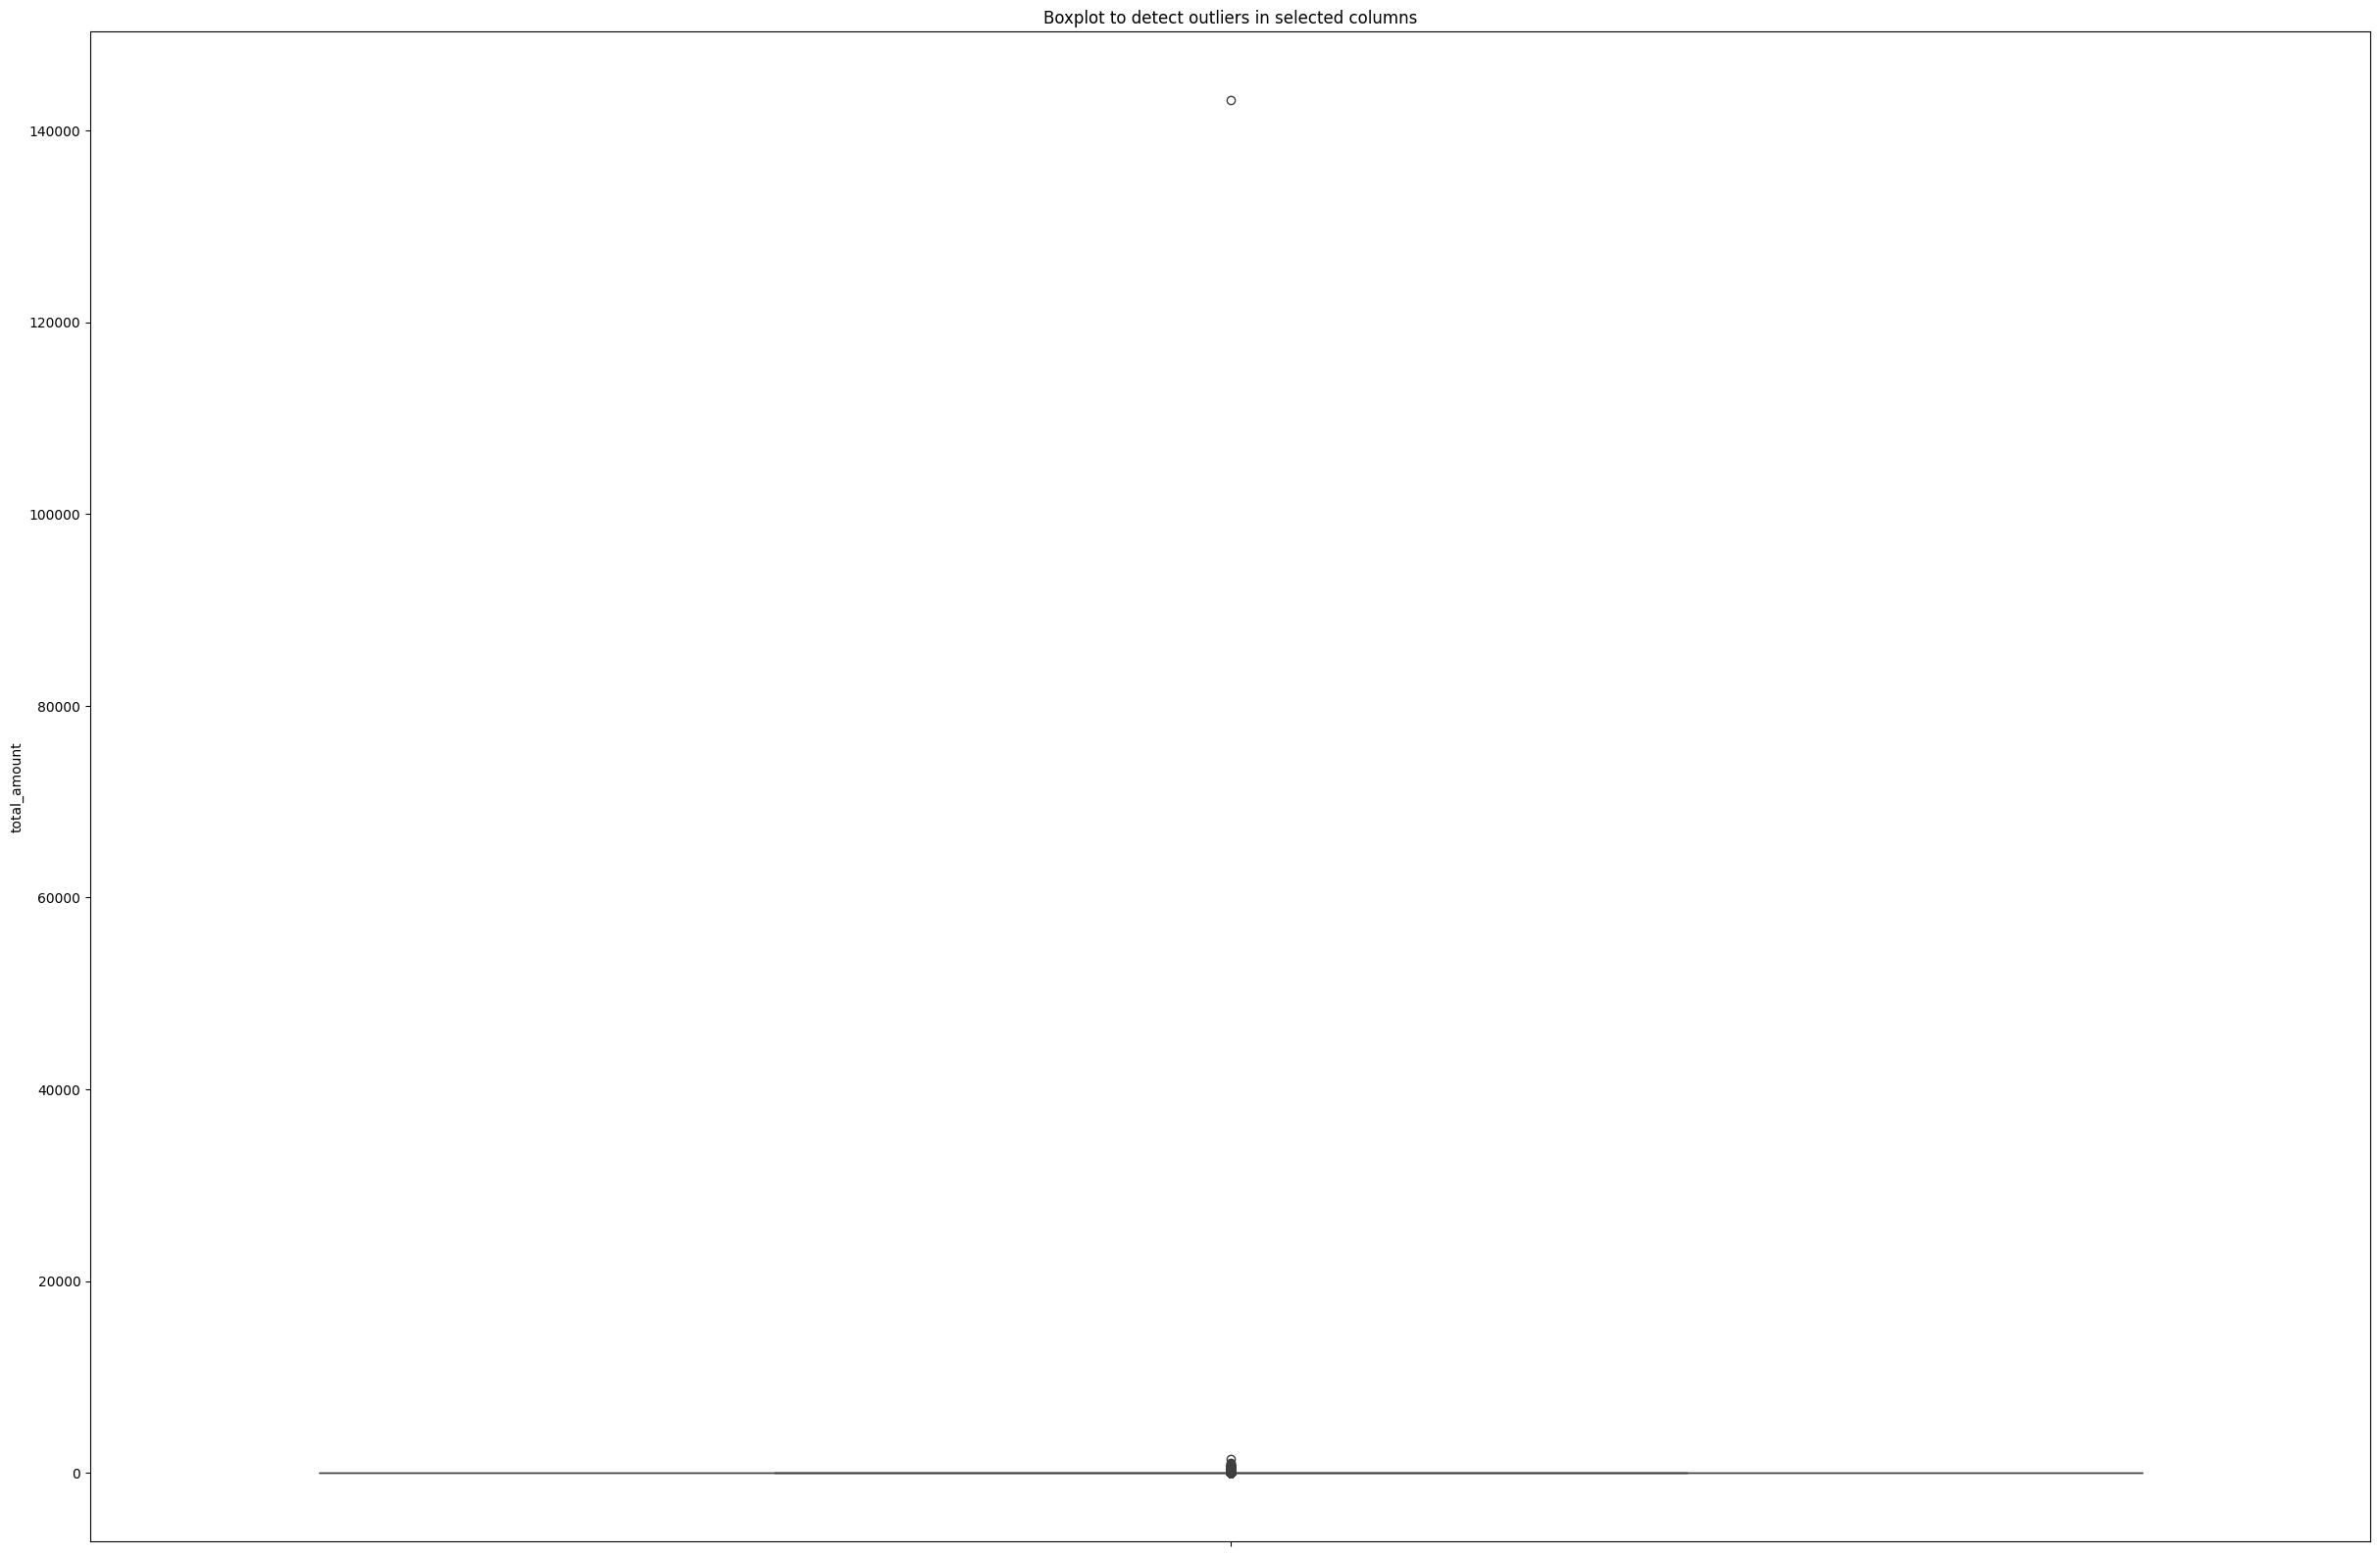

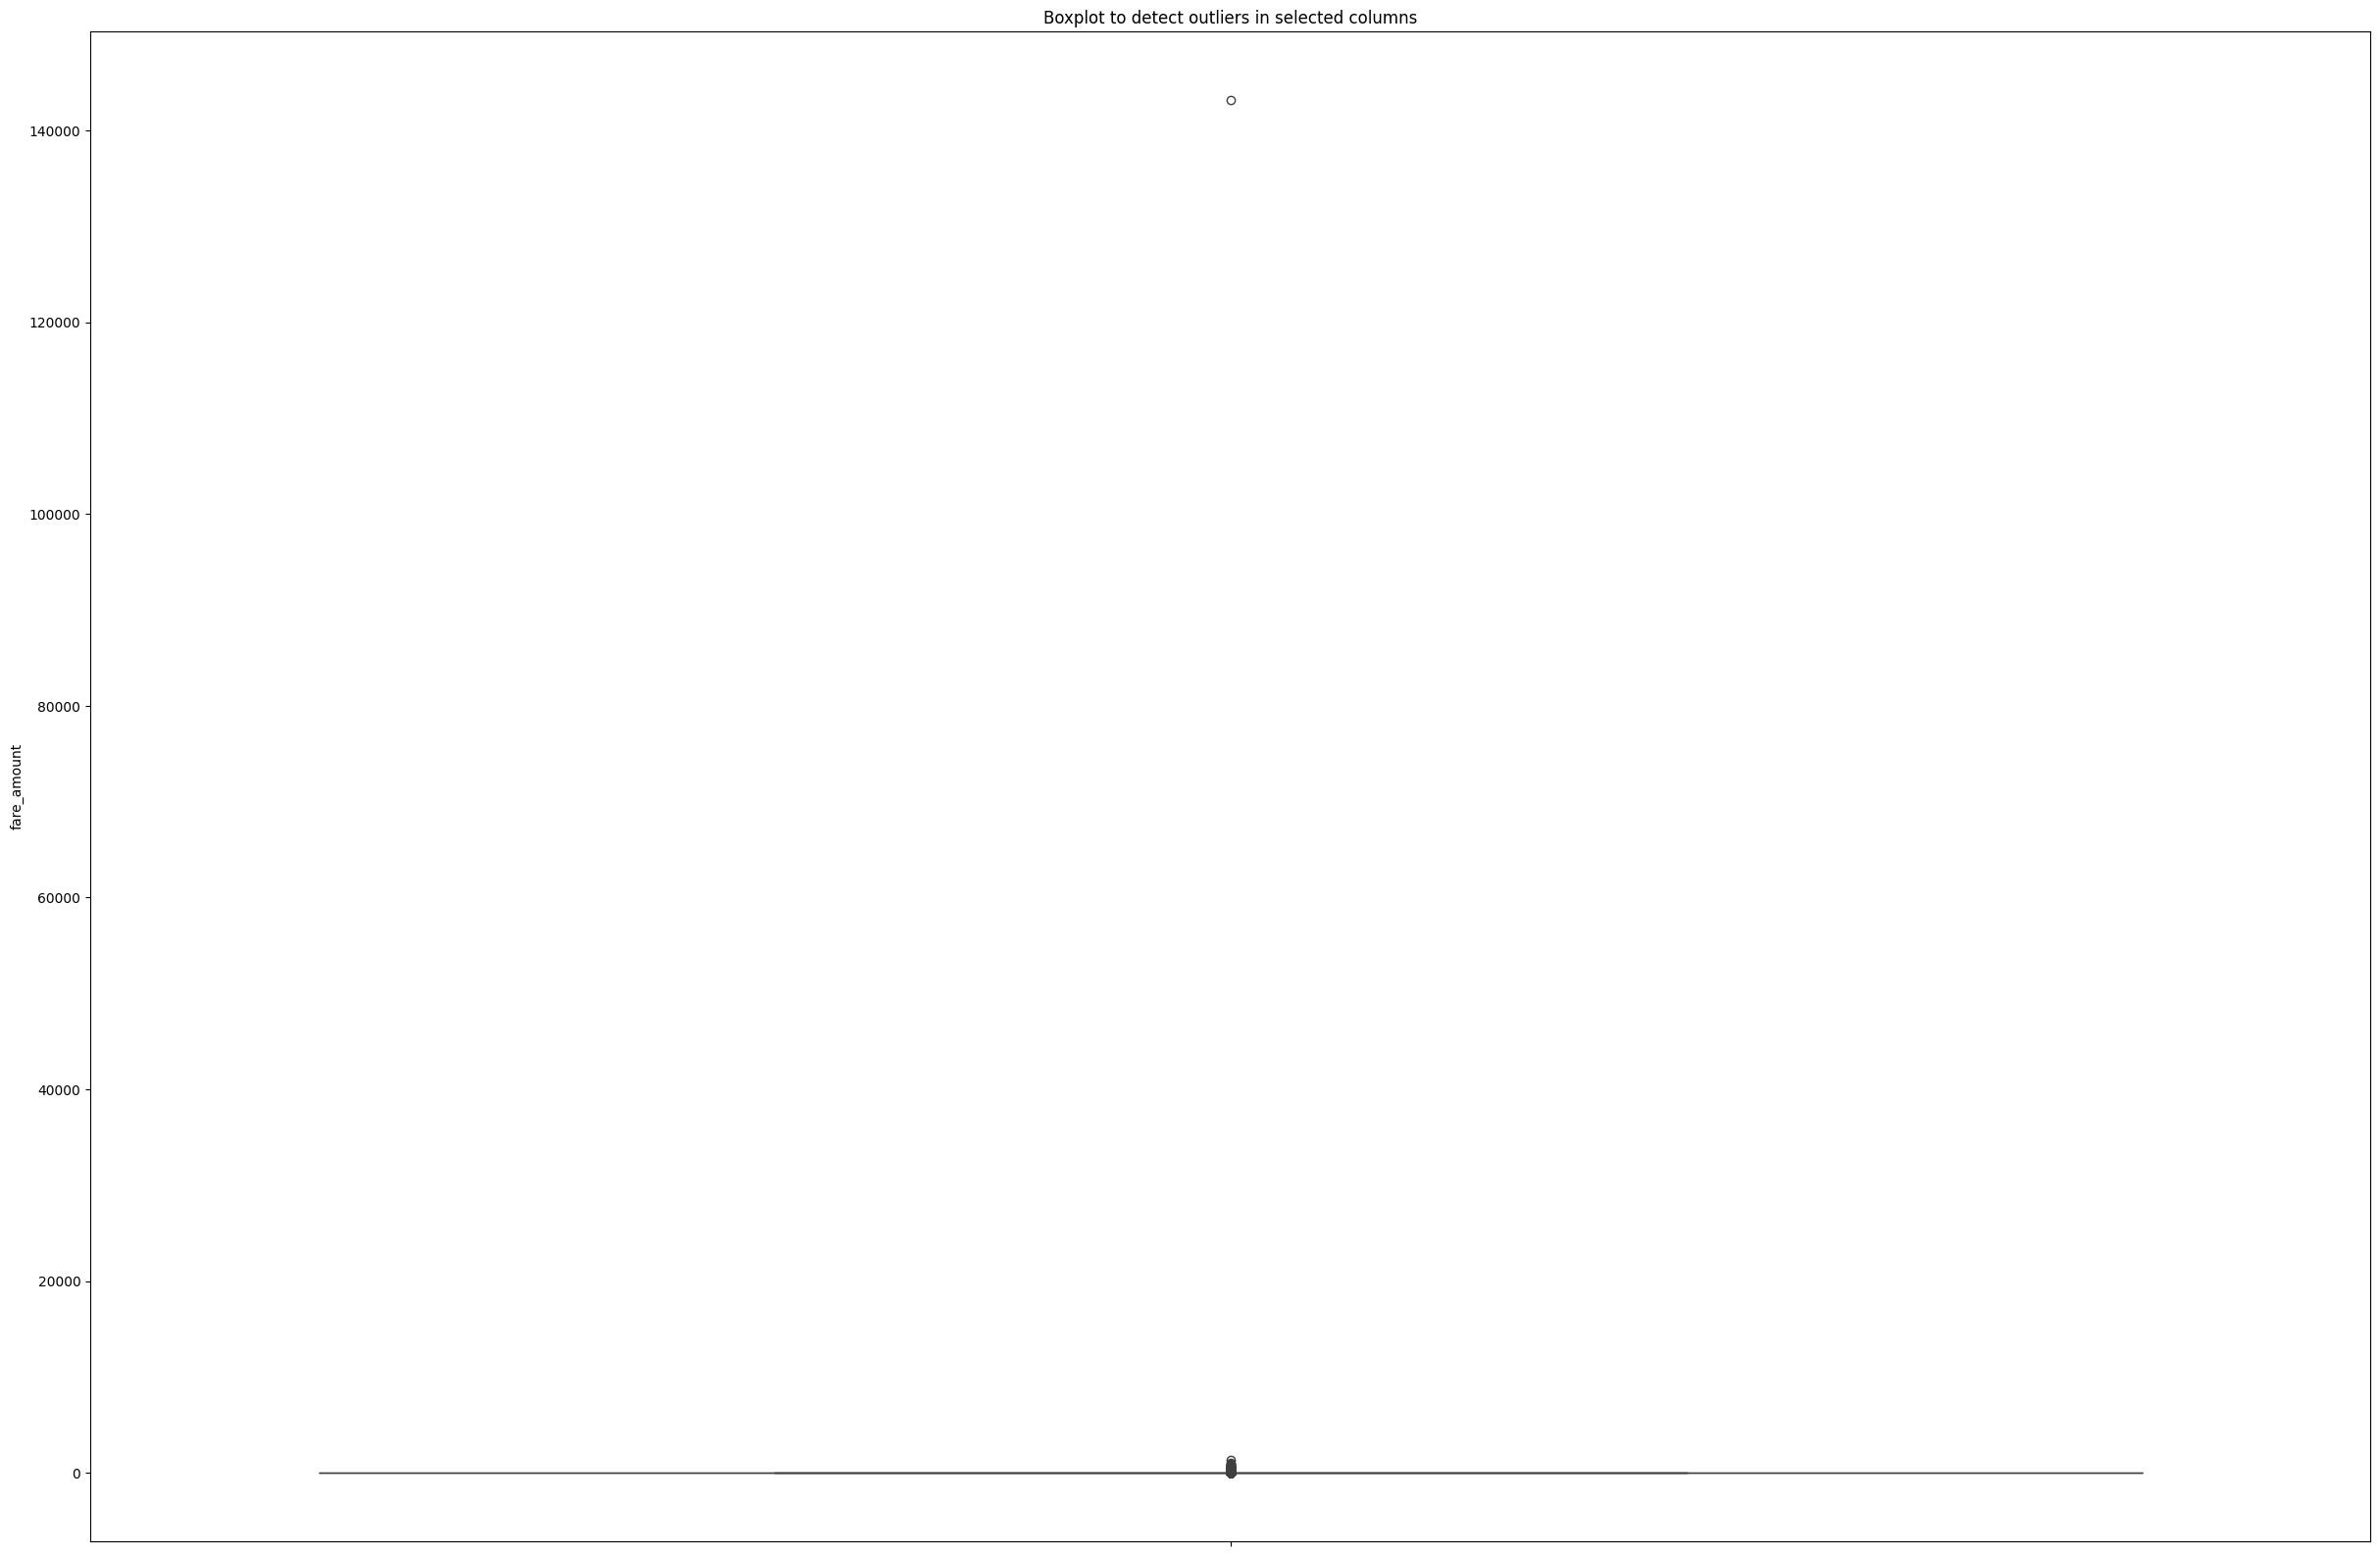

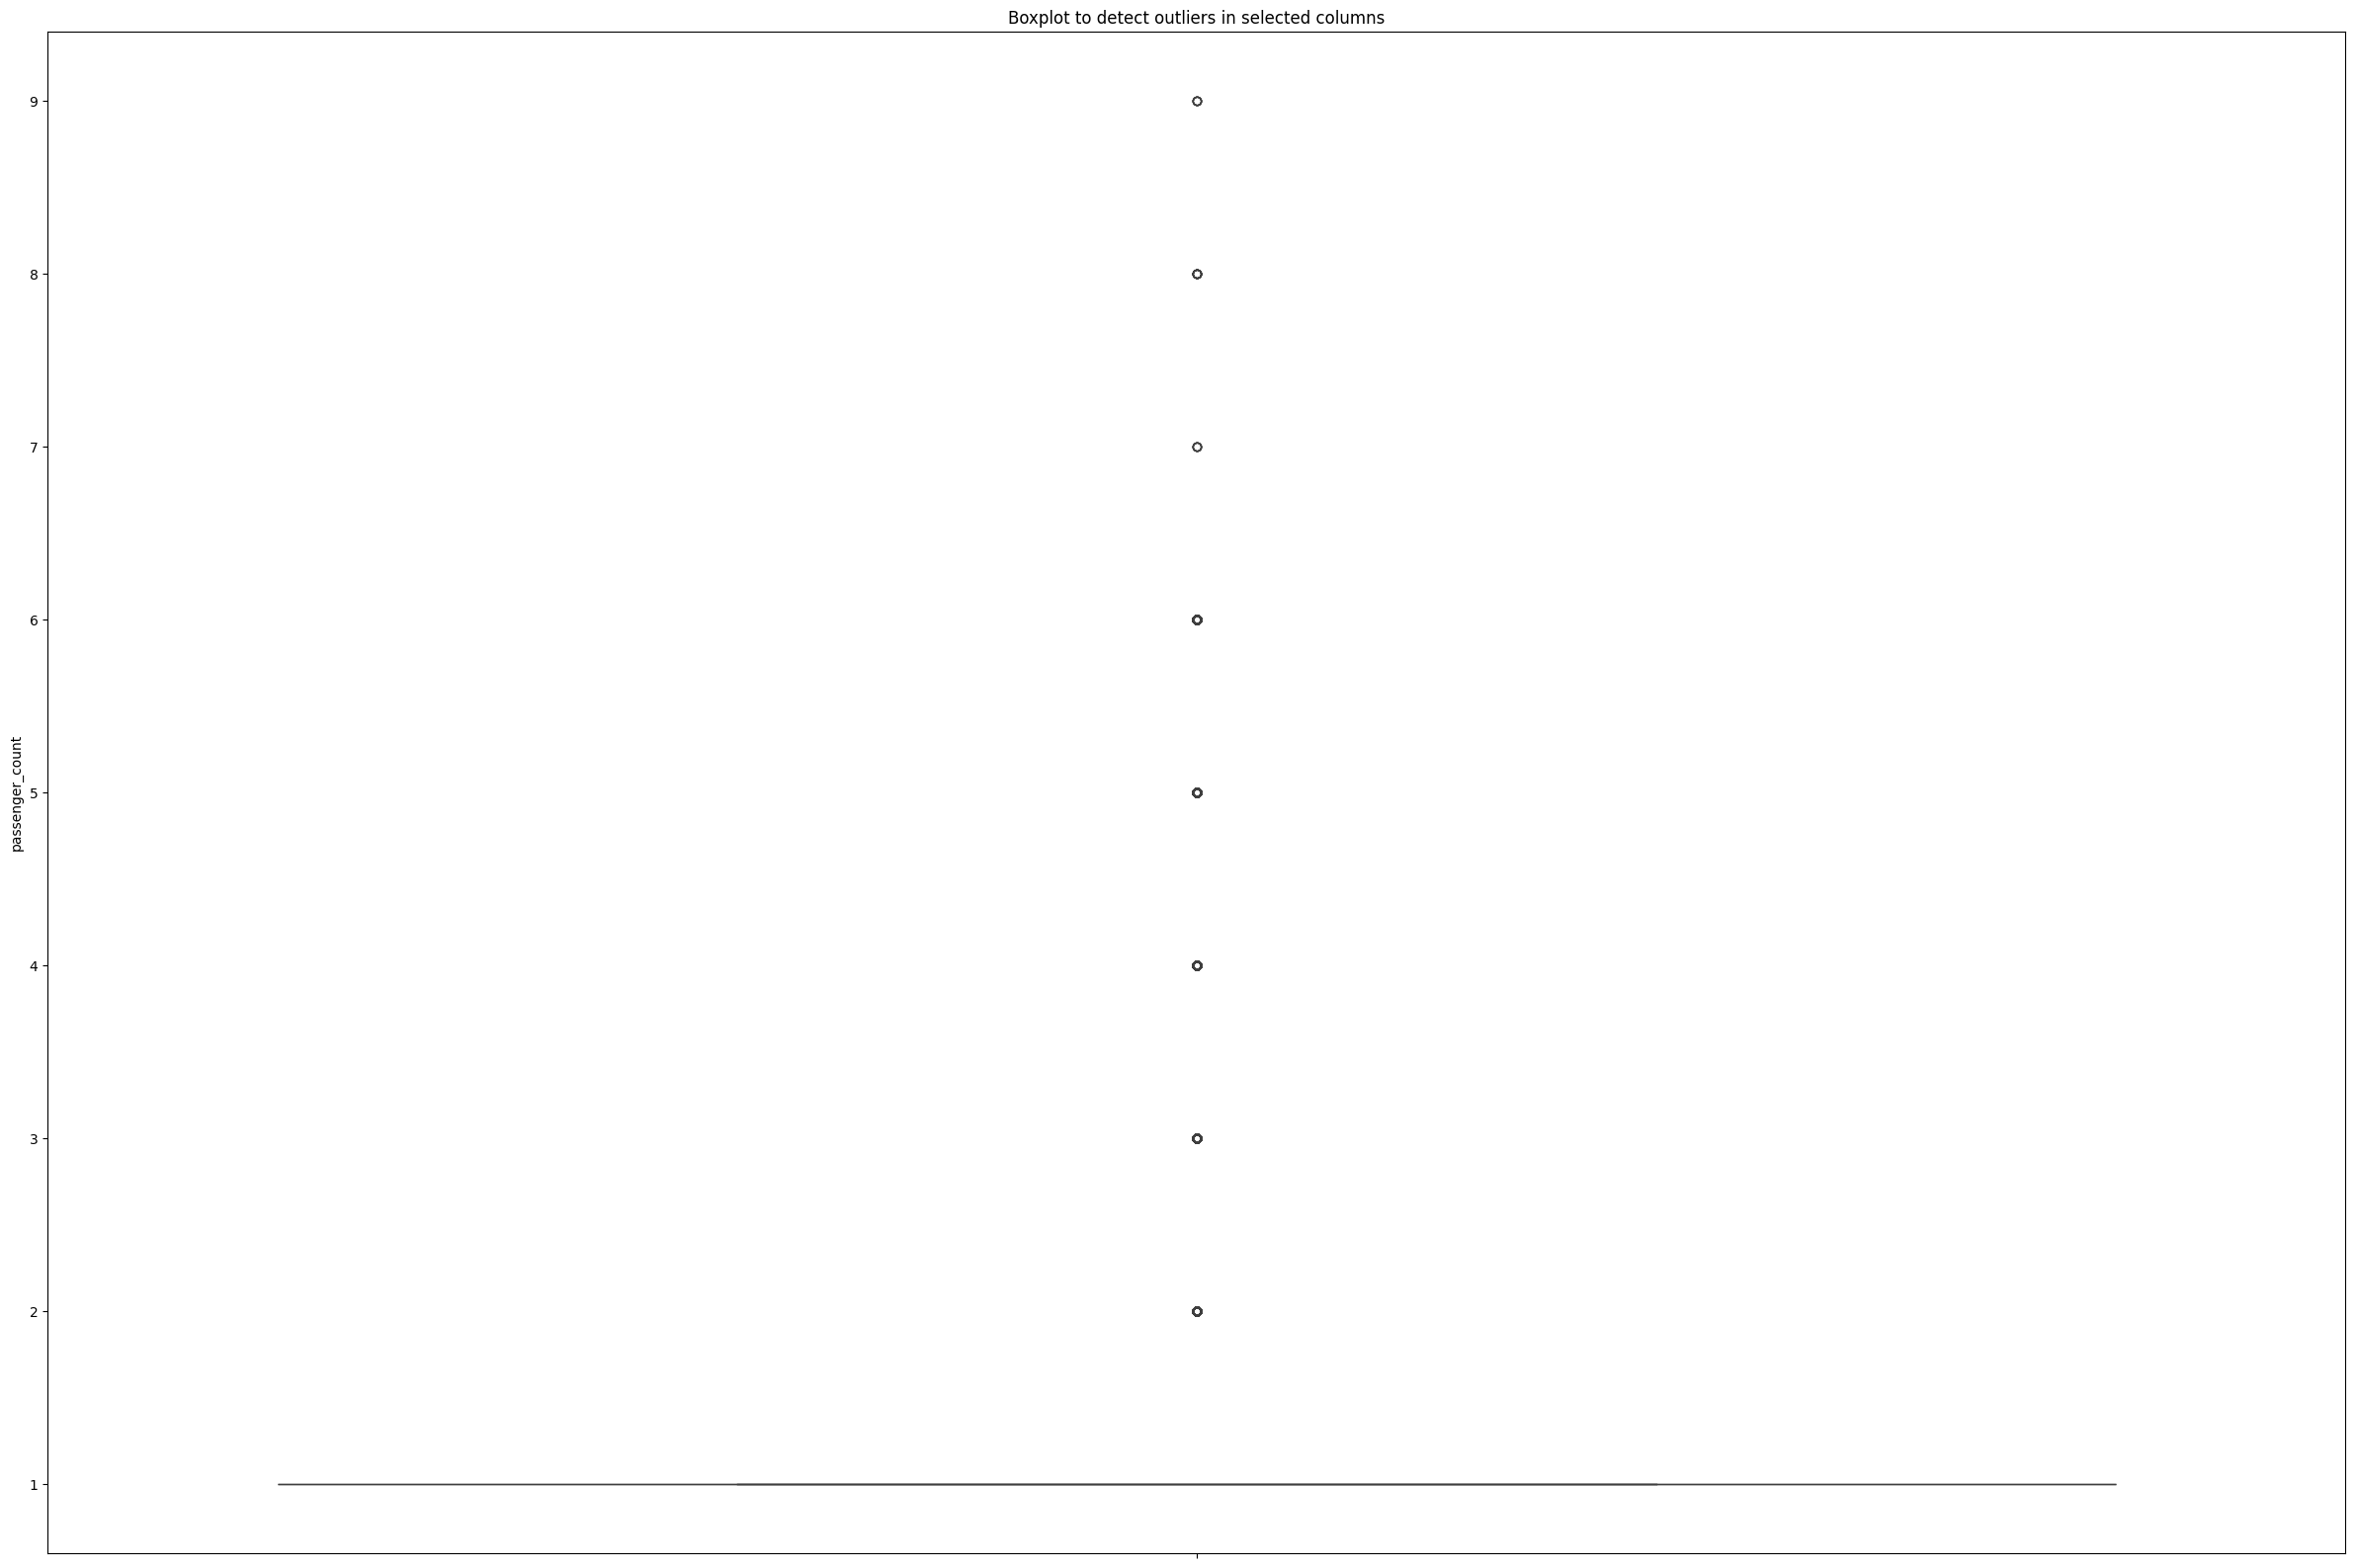

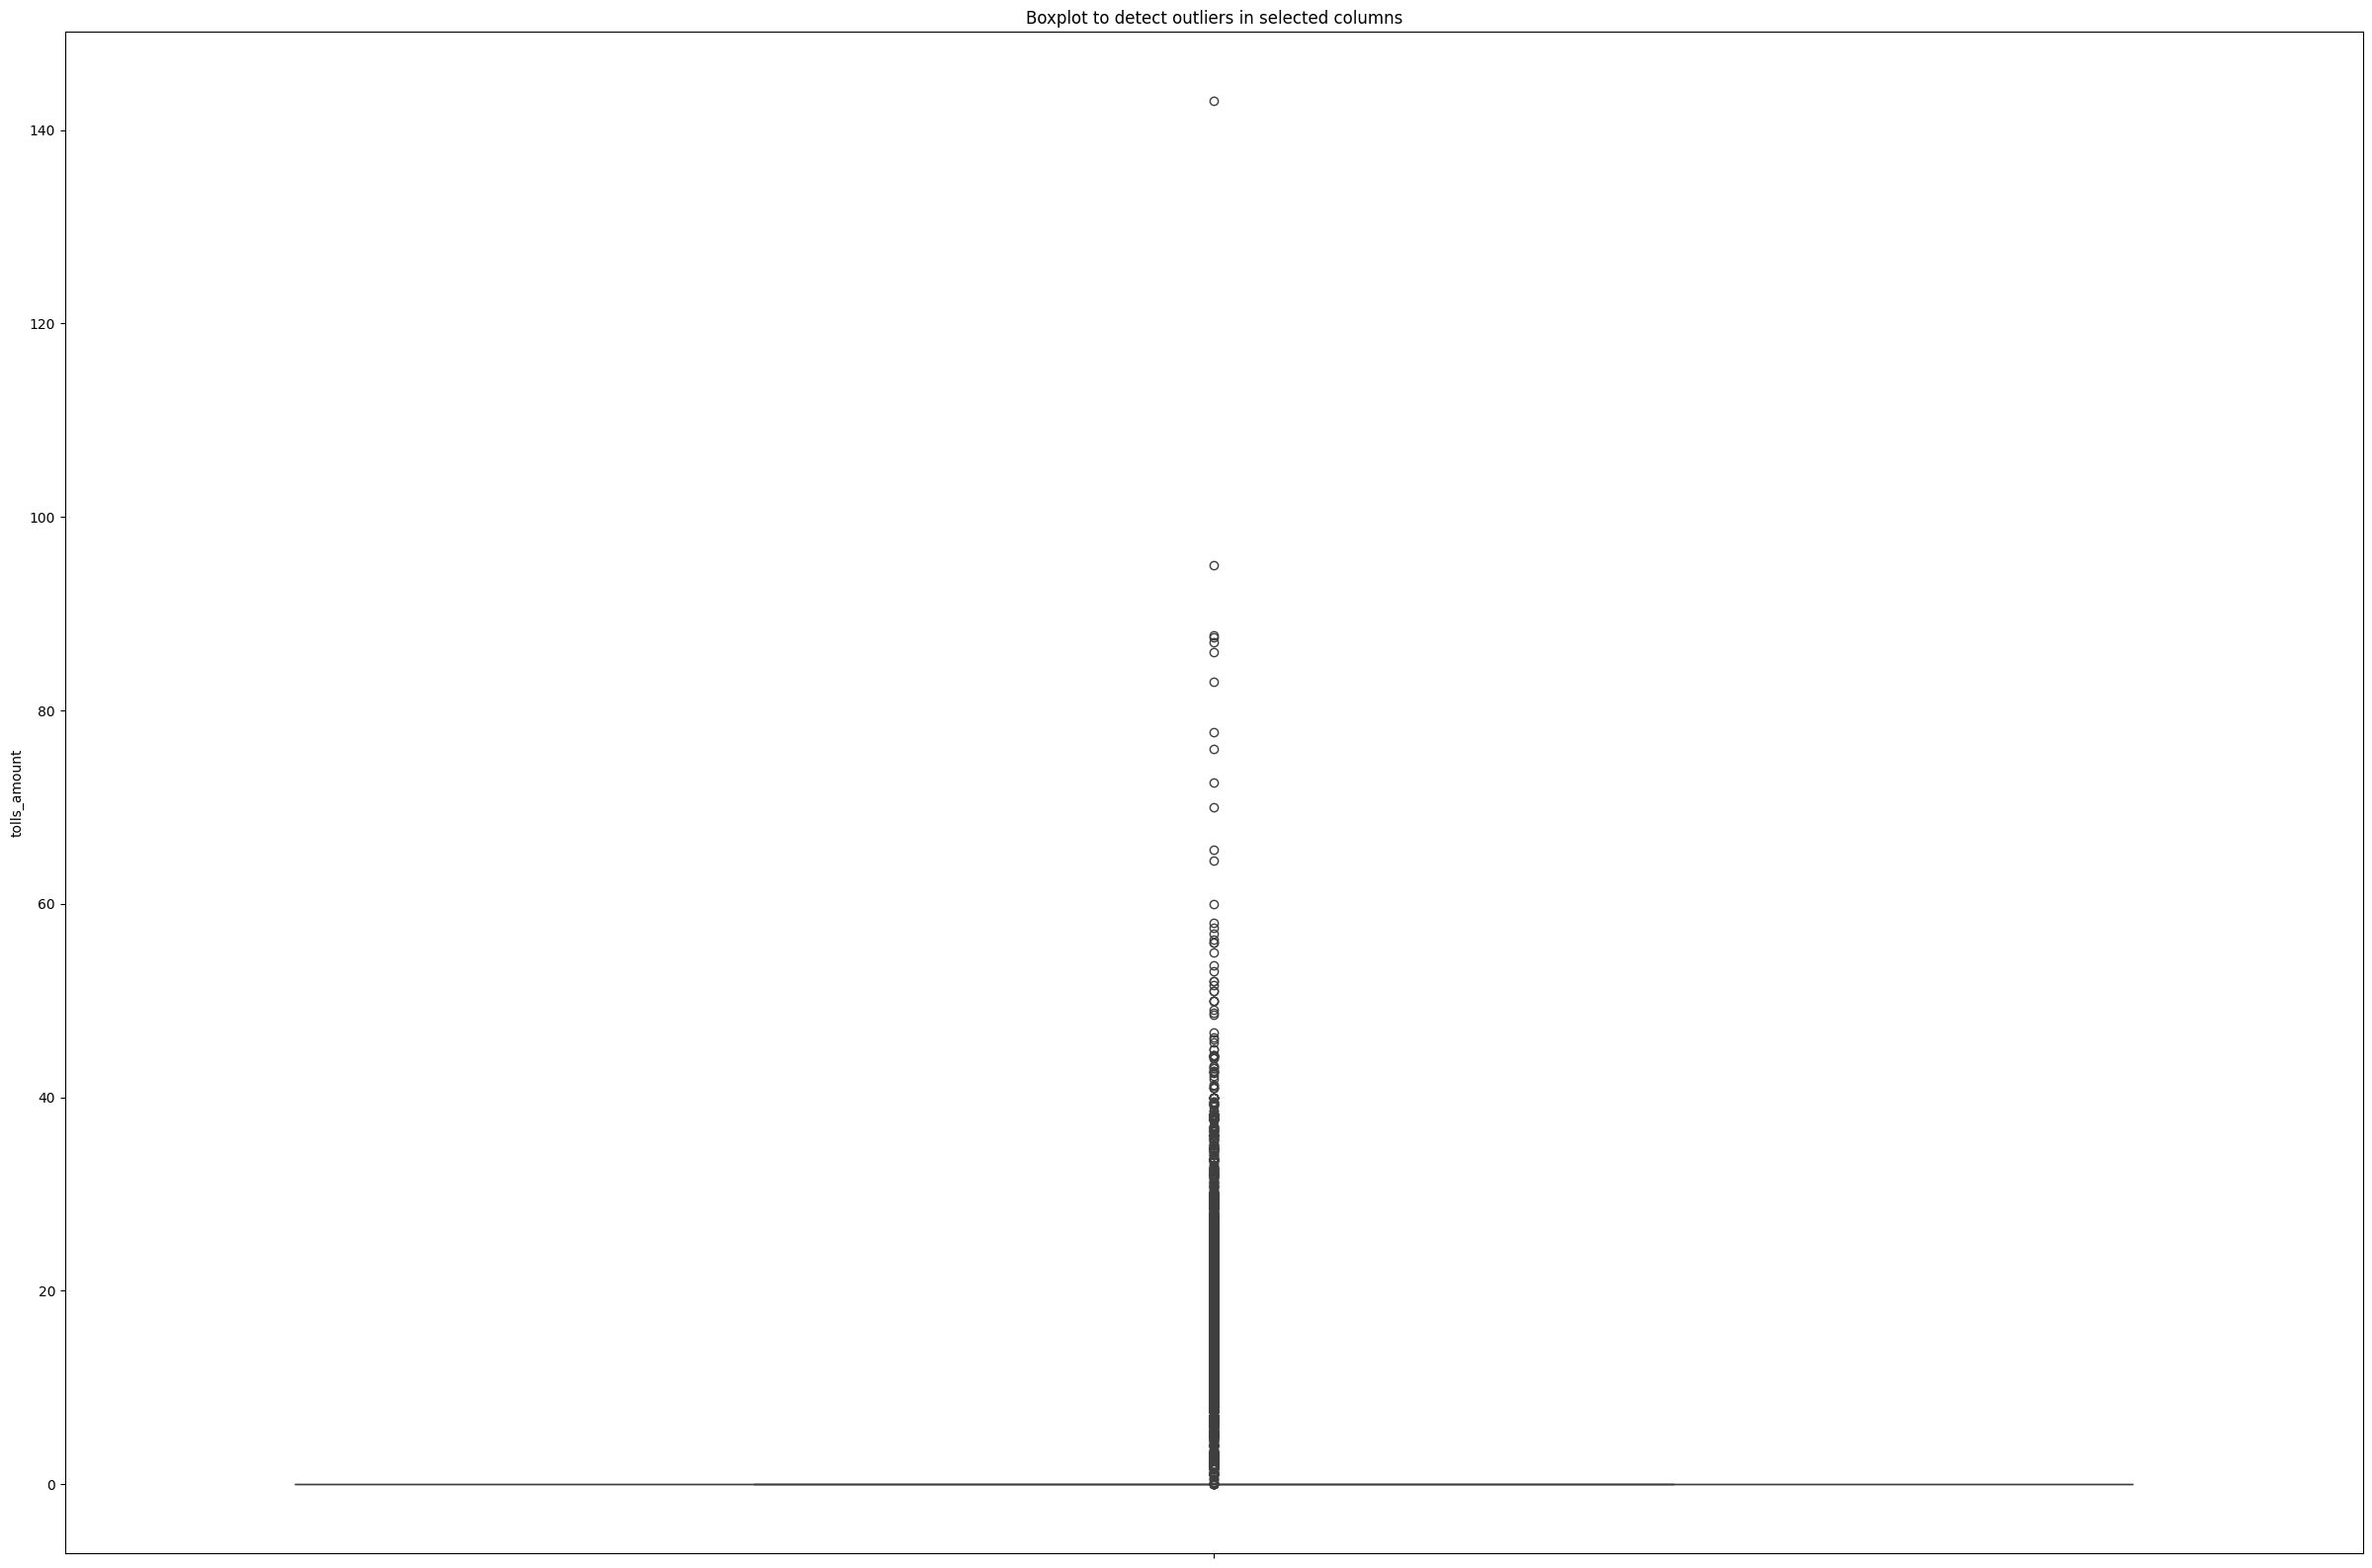

In [23]:
# Describe the data and check if there are any potential outliers present
summary = df.describe()
print(summary)
import matplotlib.pyplot as plt
import seaborn as sns


# Boxplot for numerical columns
plt.figure(figsize=(30, 20))
sns.boxplot(data=df['total_amount'])
plt.xticks(rotation=45)
plt.title('Boxplot to detect outliers in selected columns')
plt.show()

plt.figure(figsize=(30, 20))
sns.boxplot(data=df['fare_amount'])
plt.xticks(rotation=45)
plt.title('Boxplot to detect outliers in selected columns')
plt.show()


plt.figure(figsize=(30, 20))
sns.boxplot(data=df['passenger_count'])
plt.xticks(rotation=45)
plt.title('Boxplot to detect outliers in selected columns')
plt.show()

plt.figure(figsize=(30, 20))
sns.boxplot(data=df['tolls_amount'])
plt.xticks(rotation=45)
plt.title('Boxplot to detect outliers in selected columns')
plt.show()



In [45]:
# Entries where trip_distance is nearly 0 and fare_amount is more than 300
outliers_1 = df[(df['trip_distance'] < 0.1) & (df['fare_amount'] > 300)]
print("Entries where trip_distance is nearly 0 and fare_amount is more than 300:\n", outliers_1)
df = df[~((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300))]

Entries where trip_distance is nearly 0 and fare_amount is more than 300:
        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
16824         1  2023-09-05 10:16:13   2023-09-05 10:20:56              1.0   

       trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
16824      -0.605074         1.0                  N           249   

       DOLocationID  payment_type  ...  total_amount  congestion_surcharge  \
16824            90             2  ...   1366.215613              0.283174   

       airport_fee  pickup_hour  pickup_day_of_week  pickup_month  Year  \
16824    -0.297092           10                   1             9  2023   

       Month  Quarter  trip_duration  
16824      9        3       4.716667  

[1 rows x 26 columns]


In [46]:
# Entries where trip_distance and fare_amount are 0 but the pickup and dropoff zones are different
outliers_2 = df[(df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID'])]
print("Entries where trip_distance and fare_amount are 0 but the pickup and dropoff zones are different:\n", outliers_2)
df = df[~((df['trip_distance'] == 0) &
          (df['fare_amount'] == 0) &
          (df['PULocationID'] != df['DOLocationID']))]

Entries where trip_distance and fare_amount are 0 but the pickup and dropoff zones are different:
 Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, pickup_hour, pickup_day_of_week, pickup_month, Year, Month, Quarter, trip_duration]
Index: []

[0 rows x 26 columns]


In [47]:
# Entries where trip_distance is more than 250 miles
outliers_3 = df[df['trip_distance'] > 250]
print("Entries where trip_distance is more than 250 miles:\n", outliers_3)
print(outliers_3.shape)
df = df[df['trip_distance'] <= 250]



Entries where trip_distance is more than 250 miles:
 Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, pickup_hour, pickup_day_of_week, pickup_month, Year, Month, Quarter, trip_duration]
Index: []

[0 rows x 26 columns]
(0, 26)


In [48]:
# Entries where payment_type is 0
outliers_4 = df[df['payment_type'] == 0]
print("Entries where payment_type is 0:\n", outliers_4)

# Show frequency of payment types
print(df['payment_type'].value_counts())

# Find the most frequent valid payment_type (> 0)
most_common_payment_type = df[df['payment_type'] > 0]['payment_type'].mode()[0]
print("--- Most Common Valid Payment Type:", most_common_payment_type, '---')

# Replace 0s with the most common valid payment_type
df['payment_type'] = df['payment_type'].replace(0, most_common_payment_type)


Entries where payment_type is 0:
 Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, pickup_hour, pickup_day_of_week, pickup_month, Year, Month, Quarter, trip_duration]
Index: []

[0 rows x 26 columns]
payment_type
1    1609015
2     326752
4      14248
3       9353
Name: count, dtype: int64
--- Most Common Valid Payment Type: 1 ---


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [49]:
# remove passenger_count > 6
df = df[df['passenger_count'] < 6]

In [50]:
# Do any columns need standardising?
from sklearn.preprocessing import StandardScaler

numeric_cols = [
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'airport_fee'
]

# Make a copy of the relevant columns
numeric_data = df[numeric_cols]

# Initialise the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(numeric_data)

# Replace the original columns in df with the scaled ones
df[numeric_cols] = scaled_data

print("Standardisation complete. The selected numerical columns have been scaled.")



Standardisation complete. The selected numerical columns have been scaled.


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [51]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pickup_hour',
 'pickup_day_of_week',
 'pickup_month',
 'Year',
 'Month',
 'Quarter',
 'trip_duration']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

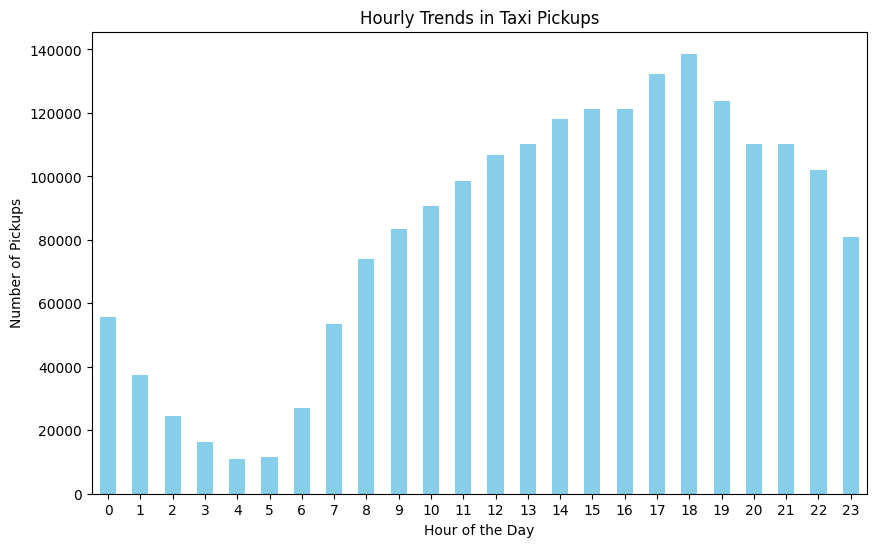

In [52]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

hourly_pickups = df.groupby('pickup_hour').size()

# Plot the results
plt.figure(figsize=(10, 6))
hourly_pickups.plot(kind='bar', color='skyblue')
plt.title('Hourly Trends in Taxi Pickups')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=0)
plt.show()


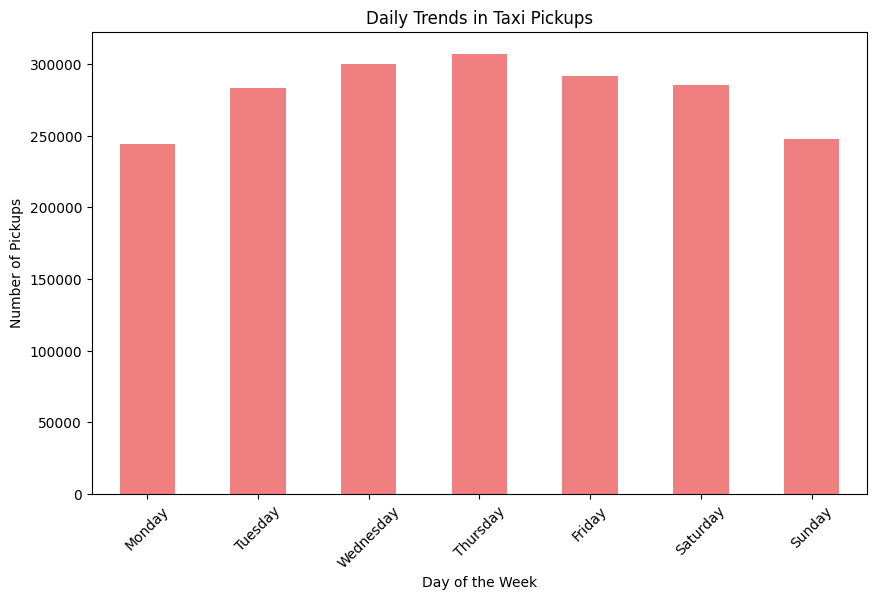

In [53]:
# Find and show the daily trends in taxi pickups (days of the week)

df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek

daily_pickups = df.groupby('pickup_day_of_week').size()

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Plot the results
plt.figure(figsize=(10, 6))
daily_pickups.index = daily_pickups.index.map(lambda x: days_of_week[x])
daily_pickups.plot(kind='bar', color='lightcoral')
plt.title('Daily Trends in Taxi Pickups')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.show()


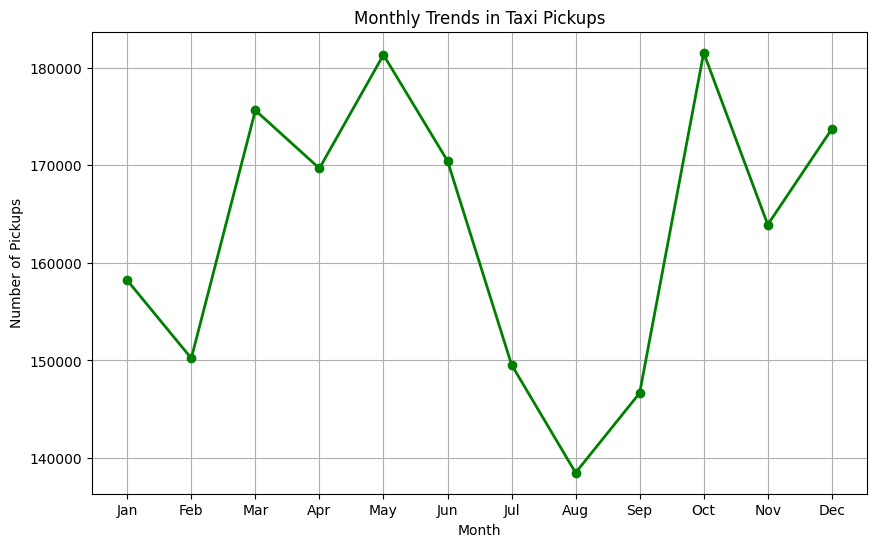

In [54]:
# Extract the month from the pickup datetime
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

monthly_pickups = df.groupby('pickup_month').size()

plt.figure(figsize=(10, 6))
monthly_pickups.plot(kind='line', marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Monthly Trends in Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()



##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [55]:
# Create a df with non zero entries for the selected parameters.
# Filter the DataFrame for non-zero entries for selected parameters
filtered_df = df[(df['trip_distance'] > 0) &
                 (df['fare_amount'] > 0) &
                 (df['payment_type'] > 0) &
                 (df['passenger_count'] > 0)]

print(filtered_df.head())

print(f"Filtered DataFrame shape: {filtered_df.shape}")



    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0          2  2023-09-01 00:39:59   2023-09-01 01:00:28              1.0   
2          2  2023-09-01 00:19:27   2023-09-01 01:04:02              2.0   
3          2  2023-09-01 00:42:13   2023-09-01 01:20:20              2.0   
7          2  2023-09-01 00:46:19   2023-09-01 01:00:11              1.0   
13         2  2023-09-01 00:15:18   2023-09-01 00:45:58              1.0   

    trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0        0.279004         1.0                  N           113           238   
2        3.310444         2.0                  N           132           163   
3        2.263219         1.0                  N           249           180   
7        0.633958         1.0                  N           233            33   
13       1.019778         1.0                  N           161            37   

    payment_type  ...  total_amount  congestion_surcharge  air

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

    Year  Month  total_amount
0   2022     12     -0.675636
1   2023      1 -10789.228984
2   2023      2 -10672.547533
3   2023      3  -5636.999129
4   2023      4  -1297.101162
5   2023      5   3534.592366
6   2023      6   3597.654776
7   2023      7   1000.675883
8   2023      8   2122.283451
9   2023      9   7829.733641
10  2023     10   6727.907614
11  2023     11   1562.523741
12  2023     12   2021.180972


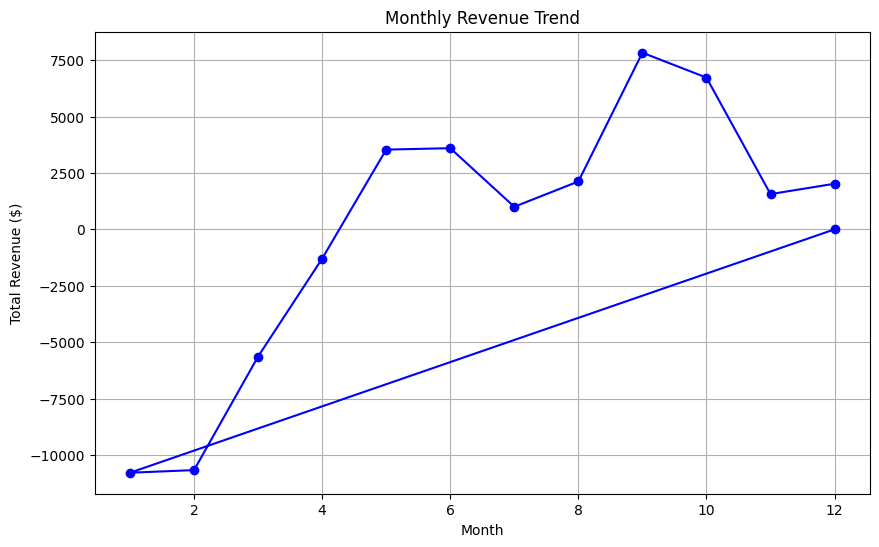

In [56]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

df['Year'] = df['tpep_pickup_datetime'].dt.year
df['Month'] = df['tpep_pickup_datetime'].dt.month

monthly_revenue = df.groupby(['Year', 'Month'])['total_amount'].sum().reset_index()

print(monthly_revenue)

plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue['Month'], monthly_revenue['total_amount'], marker='o', linestyle='-', color='b')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.grid(True)
plt.show()



**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [57]:
# Calculate proportion of each quarter
df['Quarter'] = df['tpep_pickup_datetime'].dt.quarter

quarterly_revenue = df.groupby(['Year', 'Quarter'])['total_amount'].sum().reset_index()

total_yearly_revenue = df.groupby('Year')['total_amount'].sum().reset_index()
total_yearly_revenue.rename(columns={'total_amount': 'total_yearly_revenue'}, inplace=True)
quarterly_revenue = pd.merge(quarterly_revenue, total_yearly_revenue, on='Year')

quarterly_revenue['quarter_proportion'] = quarterly_revenue['total_amount'] / quarterly_revenue['total_yearly_revenue']

# Display the results
print(quarterly_revenue)


   Year  Quarter  total_amount  total_yearly_revenue  quarter_proportion
0  2022        4     -0.675636             -0.675636            1.000000
1  2023        1 -27098.775646              0.675636       -40108.514138
2  2023        2   5835.145980              0.675636         8636.516945
3  2023        3  10952.692975              0.675636        16210.925792
4  2023        4  10311.612327              0.675636        15262.071402


**3.1.6** <font color = red>[3 marks]</font> <br>

> Add blockquote


Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [58]:
# Show how trip fare is affected by distance
correlation = df['trip_distance'].corr(df['fare_amount'])
print(f'Correlation between trip_distance and fare_amount: {correlation:.2f}')


Correlation between trip_distance and fare_amount: 0.90


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [59]:
# Show relationship between fare and trip duration

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
correlation_fare_trip_duration = df['fare_amount'].corr(df['trip_duration'])
print(f'Correlation between fare_amount and trip_duration: {correlation_fare_trip_duration:.2f}')


Correlation between fare_amount and trip_duration: 0.27


In [60]:
# Show relationship between fare and number of passengers
correlation_fare_passenger_count = df['fare_amount'].corr(df['passenger_count'])
print(correlation_fare_passenger_count)


0.049802373370889524


In [61]:
# Show relationship between tip and trip distance
correlation_tip_trip_distance = df['tip_amount'].corr(df['trip_distance'])
print(f'Correlation between tip_amount and trip_distance: {correlation_tip_trip_distance:.2f}')


Correlation between tip_amount and trip_distance: 0.57


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [63]:
payment_type_counts = df['payment_type'].value_counts()
print("Payment Type Counts:\n", payment_type_counts)



Payment Type Counts:
 payment_type
1    1609015
2     326752
4      14248
3       9353
Name: count, dtype: int64


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [43]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [44]:
# import geopandas as gpd


# Read the shapefile using geopandas
zones = # read the .shp file using gpd
zones.head()

SyntaxError: invalid syntax (<ipython-input-44-92b6d5fb067f>, line 5)

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [ ]:
# print(zones.info())
# zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [ ]:
# Merge zones and trip records using locationID and PULocationID



**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [ ]:
# Group data by location and calculate the number of trips



**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame




The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [ ]:
# Define figure and axis


# Plot the map and display it



In [ ]:
# can you try displaying the zones DF sorted by the number of trips?



Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [ ]:
# Find routes which have the slowest speeds at different times of the day



How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [ ]:
# Visualise the number of trips per hour and find the busiest hour



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [ ]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction =



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [ ]:
# Compare traffic trends for the week days and weekends



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [ ]:
# Find top 10 pickup and dropoff zones



**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [ ]:
# Find the top 10 and bottom 10 pickup/dropoff ratios



**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [ ]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones



Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [ ]:
# Filter for night hours (11 PM to 5 AM)



##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [ ]:
# Analyse the fare per mile per passenger for different passenger counts




**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [ ]:
# Compare the average fare per mile for different days and for different times of the day



**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [ ]:
# Compare fare per mile for different vendors



**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [ ]:
# Defining distance tiers



##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [ ]:
#  Analyze tip percentages based on distances, passenger counts and pickup times



Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [ ]:
# See how passenger count varies across hours and days




**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [ ]:
# How does passenger count vary across zones



In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [ ]:
# How often is each surcharge applied?



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.